# Streuung der Deadlines

In [5]:
from configs.config import get_path
import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.models.heuristics.fcfs as heuristics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 30)

In [2]:
import utils.scheduling_solver as ssv

import utils.schedule_deadline as deadline_gen
import utils.rolling_planning.init_jobs_times as rp_init

ModuleNotFoundError: No module named 'utils'

## Generierung des Datensatzes für 15 Tage (Ankunft)

In [4]:
days_numb = 15

basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = days_numb, u_b_mmax= 0.94, shuffle = True)
df_jobs_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,81.32
2,Job_002,101.67
3,Job_003,142.01
4,Job_004,177.21
...,...,...
343,Job_343,21493.38
344,Job_344,21505.82
345,Job_345,21535.97
346,Job_346,21539.07


In [6]:
df_times_all = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_times_all.rename(columns={"Deadline": "Deadline_original"}, inplace=True)
df_times_all

,Job,Arrival,Deadline_original
0,Job_000,0.00,1973.0
1,Job_001,81.32,2629.0
2,Job_002,101.67,2939.0
3,Job_003,142.01,3413.0
4,Job_004,177.21,2140.0
...,...,...,...
343,Job_343,21493.38,24041.0
344,Job_344,21505.82,24343.0
345,Job_345,21535.97,24233.0
346,Job_346,21539.07,24521.0


In [7]:
df_proc_time = df_jssp.groupby("Job", as_index=False)["Processing Time"].sum()
df_proc_time

,Job,Processing Time
0,Job_000,395
1,Job_001,510
2,Job_002,568
3,Job_003,655
4,Job_004,393
...,...,...
343,Job_343,510
344,Job_344,568
345,Job_345,540
346,Job_346,597


In [8]:
df_times_all = df_times_all.merge(df_proc_time, on="Job", how="left")
df_times_all

,Job,Arrival,Deadline_original,Processing Time
0,Job_000,0.00,1973.0,395
1,Job_001,81.32,2629.0,510
2,Job_002,101.67,2939.0,568
3,Job_003,142.01,3413.0,655
4,Job_004,177.21,2140.0,393
...,...,...,...,...
343,Job_343,21493.38,24041.0,510
344,Job_344,21505.82,24343.0,568
345,Job_345,21535.97,24233.0,540
346,Job_346,21539.07,24521.0,597


In [9]:
# b) Bestimmung der "Ready Time"
df_times_all['Ready Time'] = ((df_times_all['Arrival'] // 1440) + 1) * 1440
df_times_all


,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


## A) Normalverteilung

In [10]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


In [11]:
# Slack berechnen (ohne Prossing Time) - eigentlich "Zeitfenster" / "verfügbare Zeit"
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 2555.19
Standard Deviation of Slack: 416.15


In [12]:
np.random.seed(50)

# Berechne eine gestreute Deadline für jede Zeile:
# - Ziehe einen Wert aus einer Normalverteilung mit Mittelwert = Deadline und Streuung = std_slack
# - Stelle sicher, dass die gestreute Deadline mindestens "Arrival + Processing Time" ist
# - Weist das Ergebnis der Spalte "Gestreute_Deadline" zu

df_times["Deadline"] = df_times.apply(
    lambda row: max(
        np.random.normal(
            loc=row["Deadline_original"],         # Mittelwert = ursprüngliche Deadline
            scale=std_slack                       # konstante Standardabweichung für alle Jobs
        ),
        row["Arrival"] + row["Processing Time"]   # Minimum: frühestmögliche sinnvolle Deadline
    ),
    axis=1  # sorgt dafür, dass apply zeilenweise arbeitet
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [13]:
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Abweichung
83,Job_083,5268.37,7241.0,395,5760.0,1972.63,5664.0,-1577.0
178,Job_178,11447.34,14144.0,540,11520.0,2696.66,12979.0,-1165.0
89,Job_089,5528.05,8225.0,540,5760.0,2696.95,7156.0,-1069.0
109,Job_109,6909.40,9607.0,540,7200.0,2697.60,8590.0,-1017.0
81,Job_081,5215.45,7179.0,393,5760.0,1963.55,6192.0,-987.0
240,Job_240,15202.61,17166.0,393,15840.0,1963.39,16325.0,-841.0
310,Job_310,19781.24,22329.0,510,20160.0,2547.76,21494.0,-835.0
288,Job_288,18608.89,21156.0,510,18720.0,2547.11,20344.0,-812.0
293,Job_293,18923.74,21002.0,416,20160.0,2078.26,20193.0,-809.0
162,Job_162,10278.75,12756.0,496,11520.0,2477.25,11975.0,-781.0


In [14]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Abweichung
16,Job_016,610.41,3158.0,510,1440.0,2547.59,4538.0,1380.0
188,Job_188,12017.19,14999.0,597,12960.0,2981.81,16128.0,1129.0
52,Job_052,3513.54,6351.0,568,4320.0,2837.46,7477.0,1126.0
176,Job_176,11414.77,14686.0,655,11520.0,3271.23,15760.0,1074.0
135,Job_135,8454.99,11726.0,655,8640.0,3271.01,12752.0,1026.0
276,Job_276,17514.76,20062.0,510,18720.0,2547.24,21031.0,969.0
267,Job_267,17129.63,19208.0,416,17280.0,2078.37,20125.0,917.0
76,Job_076,4928.79,7476.0,510,5760.0,2547.21,8336.0,860.0
317,Job_317,20175.38,22653.0,496,21600.0,2477.62,23438.0,785.0
265,Job_265,16888.65,19726.0,568,17280.0,2837.35,20496.0,770.0


In [15]:
real_deviation = df_times["Abweichung"]

max_abw = real_deviation.max()
min_abw = real_deviation.min()

print(f"Ø Abweichung: {real_deviation.mean():.2f}")
print(f"Größte positive Abweichung: {max_abw:.2f}")
print(f"Größte negative Abweichung: {min_abw:.2f}")

Ø Abweichung: -20.80
Größte positive Abweichung: 1380.00
Größte negative Abweichung: -1577.00


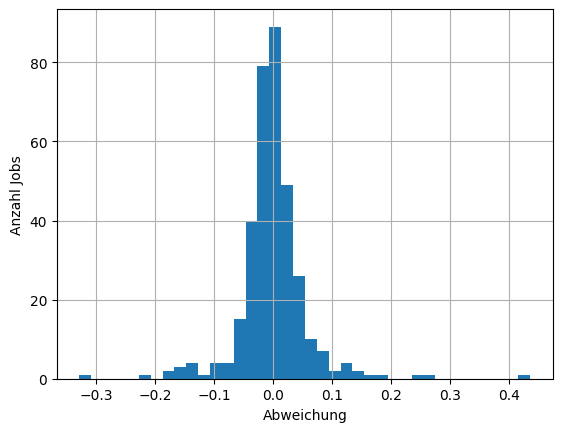

In [20]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

#### Export

In [21]:
# df_jssp.to_csv('data/09_jssp_for_17_days.csv', index=False)

In [22]:
# df_times = df_times[['Job', 'Arrival', 'Deadline']]
# df_times.to_csv('data/09_times_scattered_deadlines_for_17_days.csv', index=False)

## B) Dreiecksverteilung

In [23]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


In [24]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: np.random.triangular(
        left=row["Arrival"] + row["Processing Time"],   # frühestmögliches Ende
        mode=row["Deadline_original"],                  # Peak der Verteilung
        right=2 * row["Deadline_original"] - (row["Arrival"] + row["Processing Time"])  # symmetrisches Maximum
    ),
    axis=1
)

# Aufrunden auf nächsten ganzzahligen Wert
df_times["Deadline"] = np.ceil(df_times["Deadline"])

In [25]:
# Streuwert
df_times["Abweichung"] = df_times["Deadline"] - df_times["Deadline_original"]
min_abw = df_times["Abweichung"].min()
max_abw = df_times["Abweichung"].max()
mean_abw = df_times["Abweichung"].mean()

print(f"Minimale Abweichung: {min_abw:.2f}")
print(f"Maximale Abweichung: {max_abw:.2f}")
print(f"Mittlere Abweichung: {mean_abw:.2f}")

Minimale Abweichung: -1996.00
Maximale Abweichung: 2140.00
Mittlere Abweichung: 26.66


In [26]:
df_times.sort_values(by="Abweichung", ascending=True).head(15)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Deadline,Abweichung
321,Job_321,20342.60,23614.0,655,21600.0,21618.0,-1996.0
183,Job_183,11614.16,14886.0,655,12960.0,12943.0,-1943.0
235,Job_235,14808.85,17791.0,597,15840.0,15916.0,-1875.0
191,Job_191,12138.53,15120.0,597,12960.0,13393.0,-1727.0
112,Job_112,7055.75,9753.0,540,7200.0,8129.0,-1624.0
261,Job_261,16587.37,19569.0,597,17280.0,17979.0,-1590.0
3,Job_003,142.01,3413.0,655,1440.0,1826.0,-1587.0
278,Job_278,17682.47,20160.0,496,18720.0,18588.0,-1572.0
80,Job_080,5197.82,8035.0,568,5760.0,6580.0,-1455.0
332,Job_332,20964.36,23801.0,568,21600.0,22361.0,-1440.0


In [27]:
df_times.sort_values(by="Abweichung", ascending=False).head(15)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Deadline,Abweichung
165,Job_165,10535.14,13807.0,655,11520.0,15947.0,2140.0
71,Job_071,4694.58,7676.0,597,5760.0,9737.0,2061.0
95,Job_095,5889.72,8872.0,597,7200.0,10904.0,2032.0
197,Job_197,12440.88,15278.0,568,12960.0,17242.0,1964.0
203,Job_203,12603.52,15875.0,655,12960.0,17673.0,1798.0
174,Job_174,11144.23,13981.0,568,11520.0,15716.0,1735.0
84,Job_084,5285.08,7832.0,510,5760.0,9553.0,1721.0
12,Job_012,505.40,2983.0,496,1440.0,4695.0,1712.0
320,Job_320,20339.65,23321.0,597,21600.0,24947.0,1626.0
16,Job_016,610.41,3158.0,510,1440.0,4750.0,1592.0


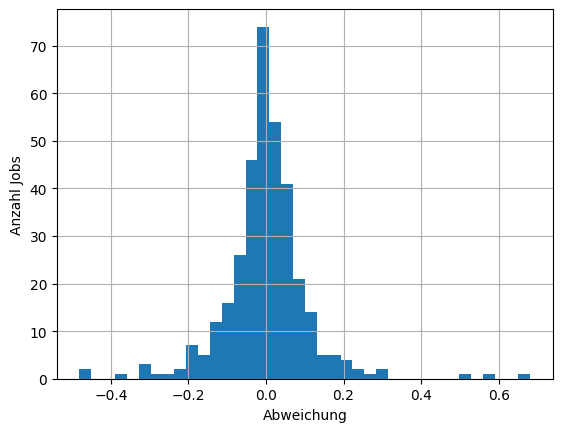

In [28]:
relative_abweichung =  (df_times["Deadline"] - df_times["Deadline_original"]) / df_times["Deadline_original"]
plt.hist(relative_abweichung , bins="auto")
plt.xlabel("Abweichung")
plt.ylabel("Anzahl Jobs")
plt.grid(True)
plt.show()

## C) Log-Normalverteilung (V1)

np.random.lognormal(mean=μ, sigma=σ)

In [30]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


In [31]:
# Slack berechnen (ohne Prossing Time) - eigentlich "Zeitfenster" / "verfügbare Zeit"
df_times["Slack"] = df_times["Deadline_original"] - df_times["Arrival"]


# Standardabweichung (und Mittelwert)der Slack-Zeiten
std_slack = df_times["Slack"].std()
mean_slack = df_times["Slack"].mean()

print(f"Mean Slack: {mean_slack:.2f}")
print(f"Standard Deviation of Slack: {std_slack:.2f}")

Mean Slack: 2555.19
Standard Deviation of Slack: 416.15


In [32]:
variance = std_slack ** 2
mu = np.log((mean_slack ** 2) / np.sqrt(variance + mean_slack ** 2))
sigma = np.sqrt(np.log(1 + (variance / (mean_slack ** 2))))


In [33]:
np.random.seed(45)

df_times["Deadline"] = df_times.apply(
    lambda row: row["Arrival"] + row["Processing Time"] + np.random.lognormal(mean=mu, sigma=sigma),
    axis=1
)

df_times["Deadline"] = np.ceil(df_times["Deadline"])


In [34]:
sigma = 0.5
np.random.seed(45)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        row["Arrival"] + row["Processing Time"] +
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
            sigma=sigma,
            size=500
        )
    ),
    axis=1
)


In [35]:
df_times = df_times.sort_values(by="Deadline")
df_times.head(20)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Deadline_List
5,Job_005,240.68,2718.0,496,1440.0,2477.32,2394.0,"[2170.132673757297, 1885.9605780084778, 2424.7..."
4,Job_004,177.21,2140.0,393,1440.0,1962.79,2624.0,"[1386.7456722444135, 2172.7059412564768, 2394...."
14,Job_014,537.27,2500.0,393,1440.0,1962.73,2831.0,"[2189.2781173253497, 3375.155821464992, 2697.1..."
0,Job_000,0.00,1973.0,395,1440.0,1973.00,2928.0,"[2159.279891176088, 2378.208678527891, 1824.01..."
12,Job_012,505.40,2983.0,496,1440.0,2477.60,2989.0,"[3087.1716621120945, 3314.6908218146655, 5319...."
2,Job_002,101.67,2939.0,568,1440.0,2837.33,3036.0,"[3960.766164292666, 3474.39559402809, 4452.370..."
7,Job_007,315.62,3008.0,539,1440.0,2692.38,3045.0,"[5022.305137364182, 5254.307566488515, 5879.18..."
1,Job_001,81.32,2629.0,510,1440.0,2547.68,3222.0,"[2350.63938396681, 1199.5788714913479, 4598.87..."
3,Job_003,142.01,3413.0,655,1440.0,3270.99,3237.0,"[5439.651977789436, 4030.3608821729213, 4334.8..."
16,Job_016,610.41,3158.0,510,1440.0,2547.59,3263.0,"[5413.054753452713, 3512.9732827372463, 4229.8..."


In [36]:
df_times.tail(20)

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Slack,Deadline,Deadline_List
305,Job_305,19645.42,22123.0,496,20160.0,2477.58,23661.0,"[52280.70223232248, 54856.72771421942, 37506.0..."
327,Job_327,20591.01,22554.0,393,21600.0,1962.99,23670.0,"[47587.07594857915, 72059.70179339132, 38747.0..."
332,Job_332,20964.36,23801.0,568,21600.0,2836.64,23675.0,"[39475.05038903954, 31877.97209458512, 30000.9..."
314,Job_314,20143.23,23415.0,655,20160.0,3271.77,23685.0,"[36686.82687770098, 35937.400641011496, 29216...."
324,Job_324,20452.63,22930.0,496,21600.0,2477.37,23710.0,"[70943.25612598601, 55756.898846467055, 85320...."
333,Job_333,21039.66,23003.0,393,21600.0,1963.34,23857.0,"[39874.33545683495, 54682.602628192544, 53431...."
326,Job_326,20590.95,22669.0,416,21600.0,2078.05,23902.0,"[38930.80840358995, 79282.2144964239, 46378.36..."
330,Job_330,20865.15,22943.0,416,21600.0,2077.85,23934.0,"[83673.17721039323, 33019.33896327755, 41960.5..."
342,Job_342,21475.74,24747.0,655,21600.0,3271.26,24153.0,"[38614.85117175468, 53469.237686470784, 66552...."
345,Job_345,21535.97,24233.0,540,21600.0,2697.03,24215.0,"[46473.58720360148, 33424.20791787394, 40050.8..."


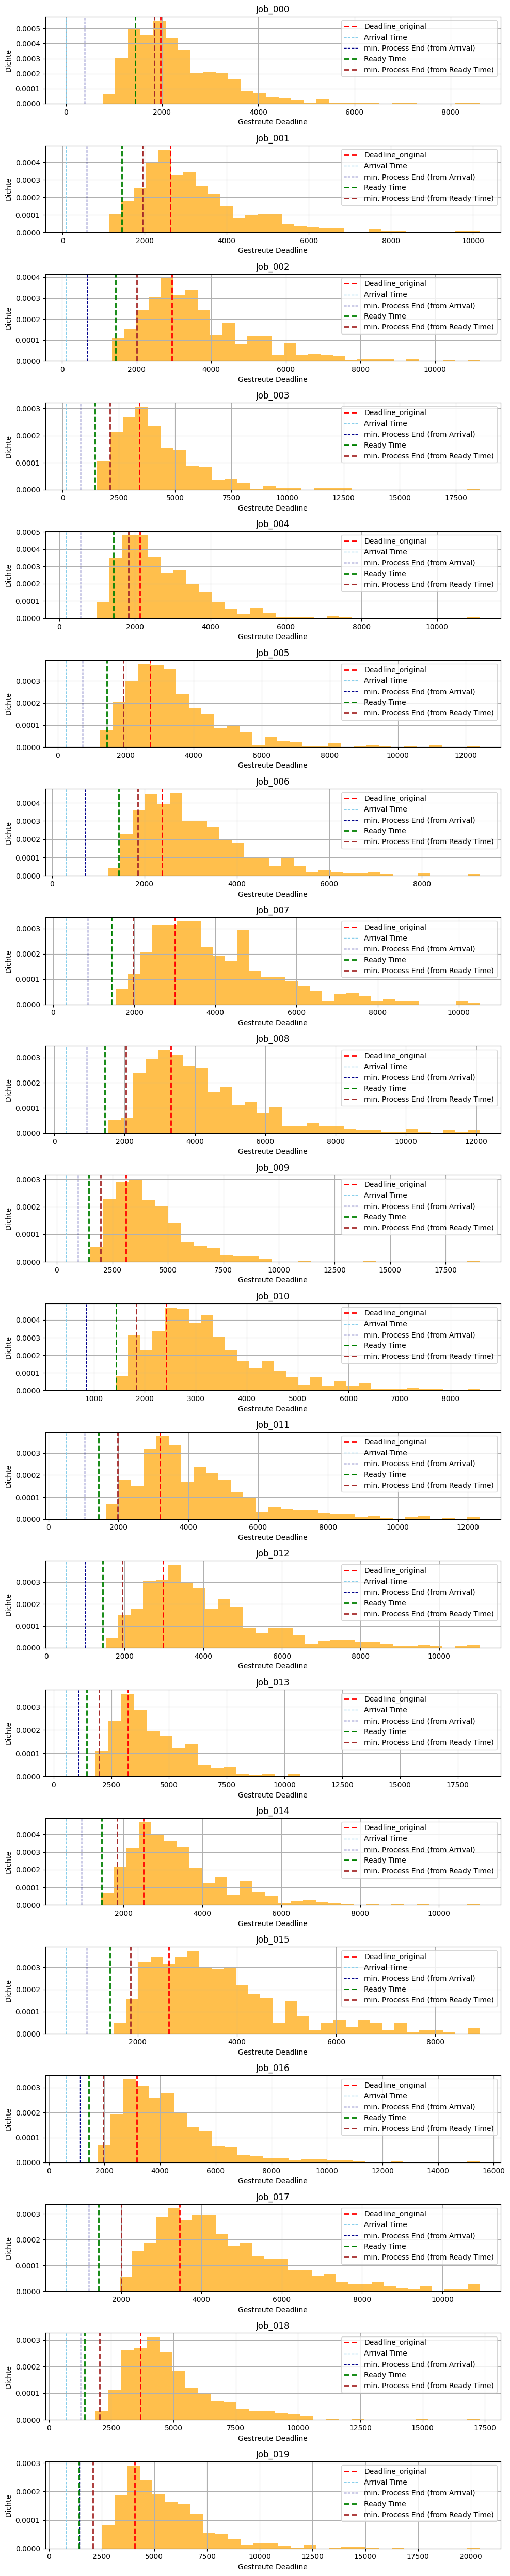

In [37]:
df_plot = df_times.sort_values(by="Job").head(20)
#df_plot = df_times.sort_values(by="Job").tail(5)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## D) Log-Normalverteilung (V2)

In [38]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


In [39]:
sigma = 0.5  # frei wählbare Streuung (z. B. 0.2 bis 0.6 ist oft sinnvoll)
np.random.seed(41)

df_times["Deadline"] = df_times.apply(
    lambda row: np.ceil(
        max(
            np.random.lognormal(
                mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
                sigma=sigma
            ),
            row["Arrival"] + row["Processing Time"]
        )
    ),
    axis=1
)


In [40]:
sigma = 0.5
np.random.seed(41)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) - 0.5 * sigma**2,
            sigma=sigma,
            size=1000
        )
    ),
    axis=1
)


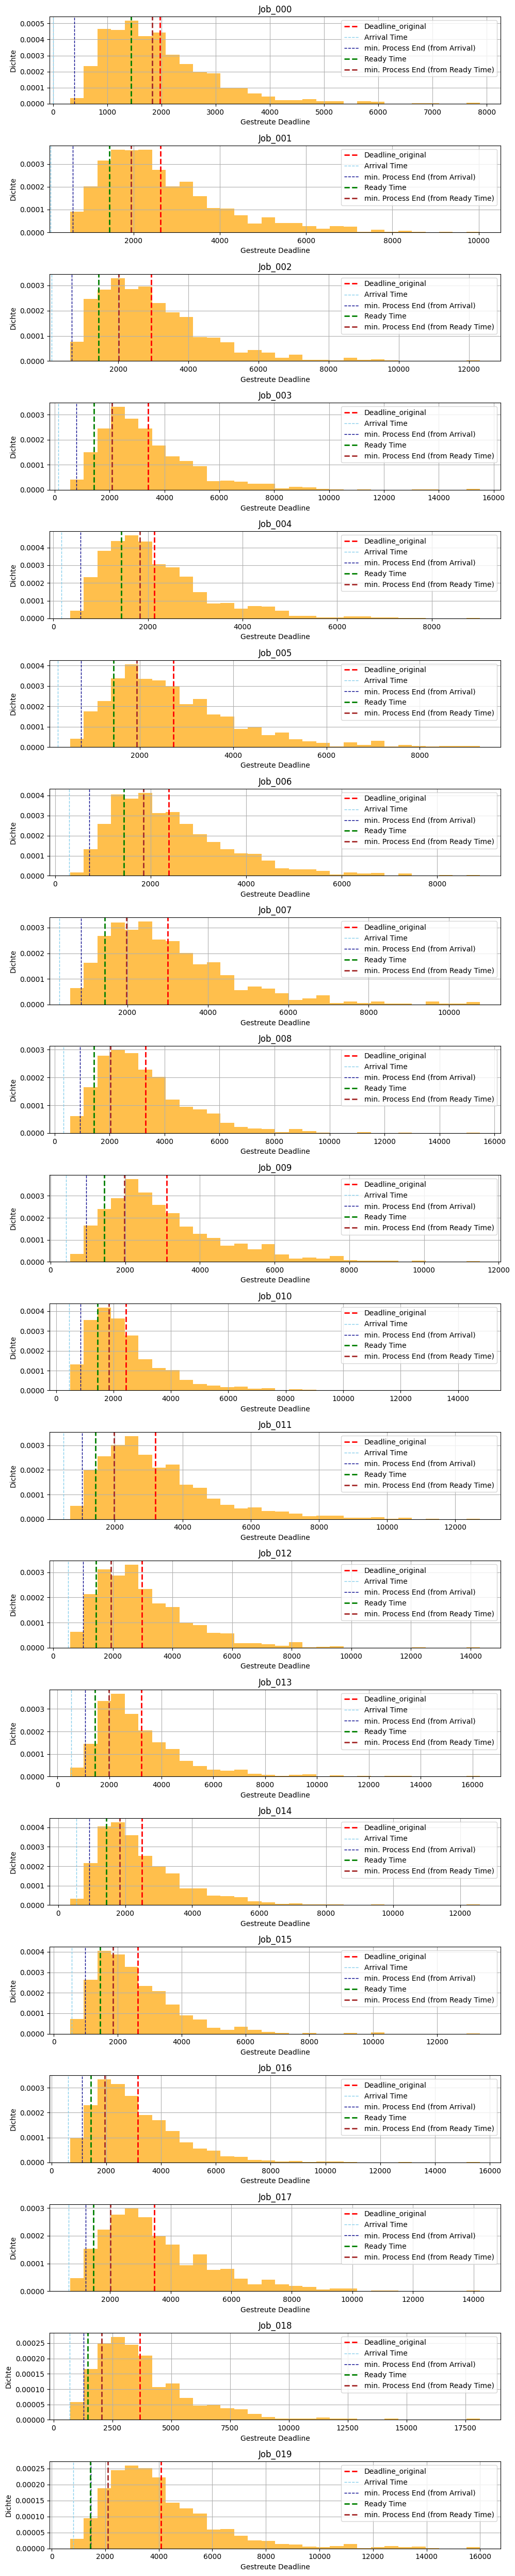

In [41]:
df_plot = df_times.sort_values(by="Job").head(20)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## E) Log-Normalverteilung (V3)
> Modus = original Deadline

In [42]:
df_times = df_times_all.copy()
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time
0,Job_000,0.00,1973.0,395,1440.0
1,Job_001,81.32,2629.0,510,1440.0
2,Job_002,101.67,2939.0,568,1440.0
3,Job_003,142.01,3413.0,655,1440.0
4,Job_004,177.21,2140.0,393,1440.0
...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0
344,Job_344,21505.82,24343.0,568,21600.0
345,Job_345,21535.97,24233.0,540,21600.0
346,Job_346,21539.07,24521.0,597,21600.0


In [43]:
sigma = 0.5
np.random.seed(41)

df_times["Deadline_List"] = df_times.apply(
    lambda row: list(
        np.random.lognormal(
            mean=np.log(row["Deadline_original"]) + sigma**2,
            sigma=sigma,
            size=1000
        )
    ),
    axis=1
)


In [44]:
df_times

,Job,Arrival,Deadline_original,Processing Time,Ready Time,Deadline_List
0,Job_000,0.00,1973.0,395,1440.0,"[2212.6680847146176, 2669.735098233487, 2871.4..."
1,Job_001,81.32,2629.0,510,1440.0,"[2499.1494875772164, 3020.214046057051, 4830.5..."
2,Job_002,101.67,2939.0,568,1440.0,"[1747.6697984703903, 5796.797740038986, 1222.5..."
3,Job_003,142.01,3413.0,655,1440.0,"[2298.270790784115, 4390.295034143824, 2327.02..."
4,Job_004,177.21,2140.0,393,1440.0,"[3210.558529582763, 3410.322833205807, 2919.38..."
...,...,...,...,...,...,...
343,Job_343,21493.38,24041.0,510,21600.0,"[27093.397850055037, 17813.129889976786, 26841..."
344,Job_344,21505.82,24343.0,568,21600.0,"[35857.25757369964, 27684.109436989307, 29645...."
345,Job_345,21535.97,24233.0,540,21600.0,"[36111.42240788471, 29225.655940191293, 53693...."
346,Job_346,21539.07,24521.0,597,21600.0,"[28614.038298272357, 25730.727248025654, 40610..."


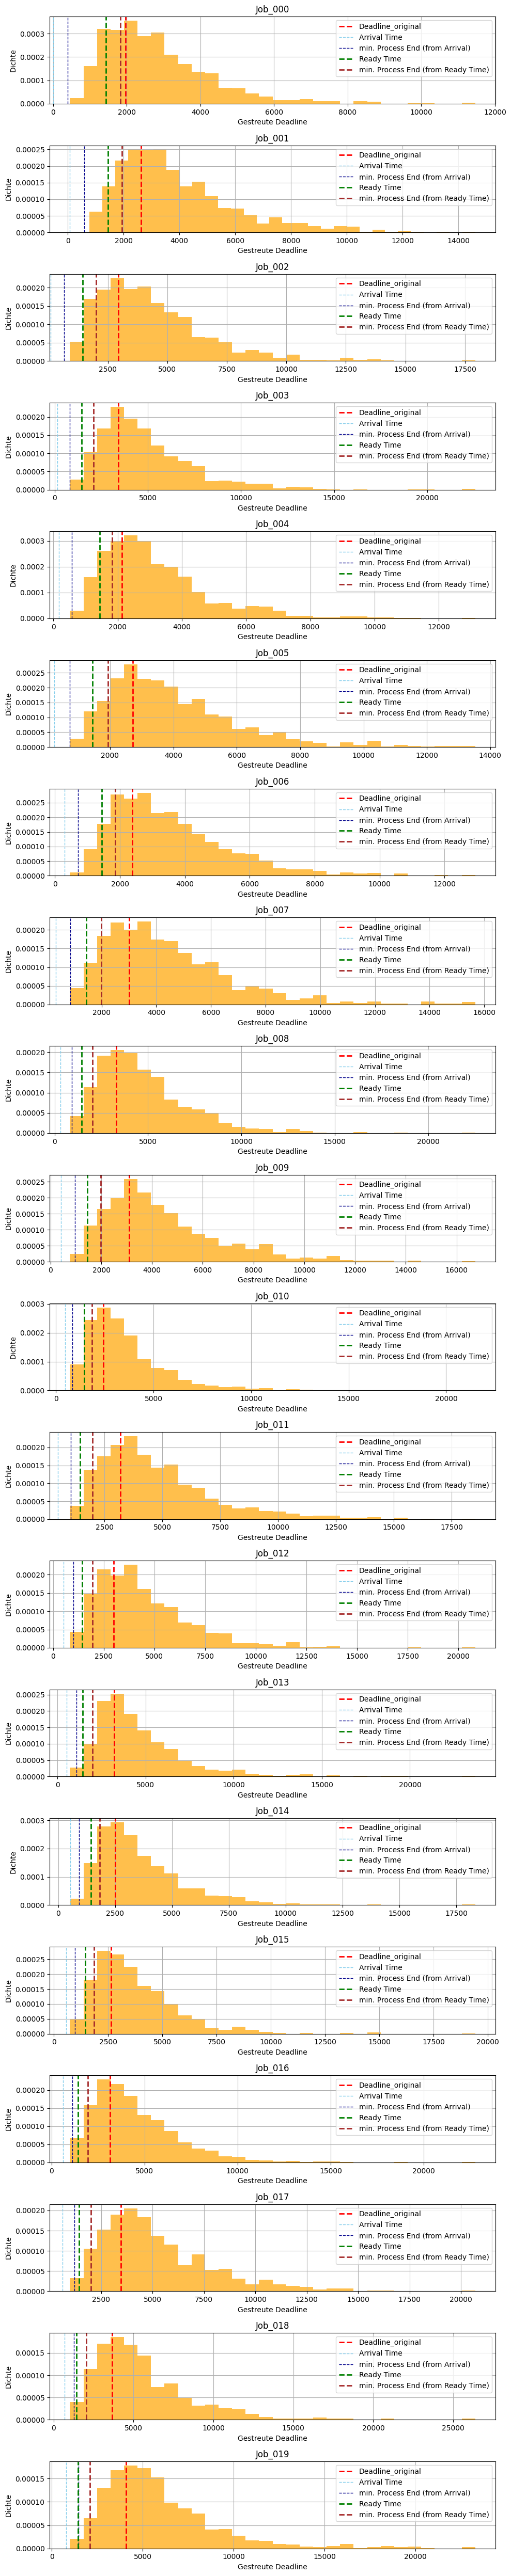

In [45]:
df_plot = df_times.sort_values(by="Job").head(20)

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=30, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

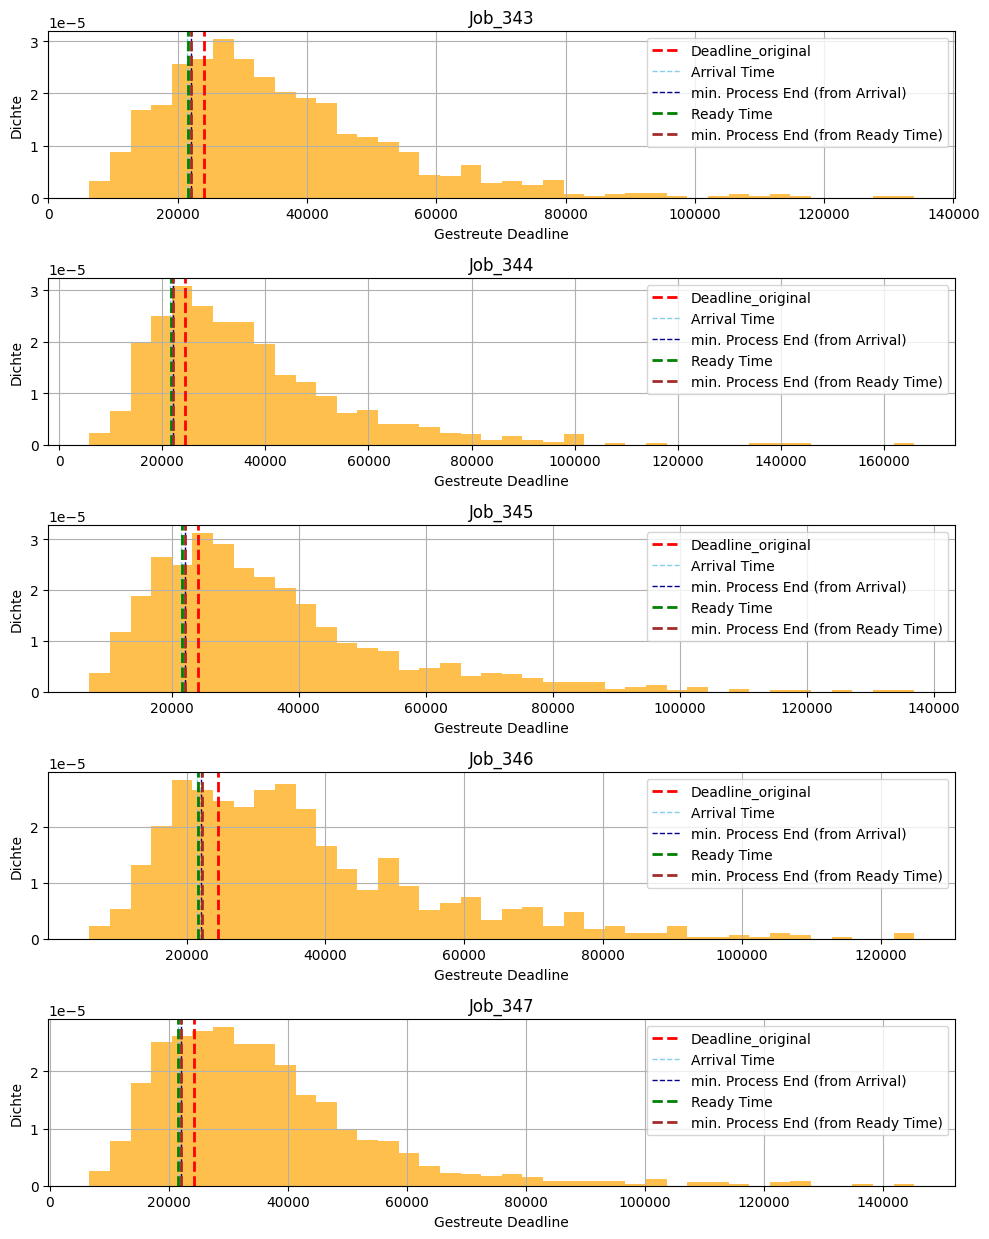

In [46]:
df_plot = df_times.sort_values(by="Job").tail()

# Plots untereinander, mit vertikalem Strich für Deadline_original
fig, axes = plt.subplots(len(df_plot), 1, figsize=(10, len(df_plot) * 2.5))

for idx, (i, row) in enumerate(df_plot.iterrows()):
    ax = axes[idx]
    ax.hist(row["Deadline_List"], bins=40, density=True, alpha=0.7, color='orange')
    ax.axvline(row["Deadline_original"], color='red', linestyle='--', linewidth=2, label='Deadline_original')

    ax.axvline(row["Arrival"], color='#87CEEB', linestyle='--', linewidth=1, label='Arrival Time')
    ax.axvline(row["Arrival"]+ row["Processing Time"], color='#00008B', linestyle='--', linewidth=1, label='min. Process End (from Arrival)')
    ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')
    ax.axvline(row["Ready Time"]+ row["Processing Time"], color='brown', linestyle='--', linewidth=2, label='min. Process End (from Ready Time)')
    ax.set_title(f'{row["Job"]}')
    ax.set_xlabel("Gestreute Deadline")
    ax.set_ylabel("Dichte")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()